# Autoencoder Denoising con NILMTK
Este es un ejemplo de cómo entrenar y usar el desagregador del Autoencoder Denoising (DAE) en el conjunto de datos REDD usando NILMTK.

In [1]:
from __future__ import print_function, division
import time

from matplotlib import rcParams
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from six import iteritems

from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore
from nilmtk.legacy.disaggregate import CombinatorialOptimisation, FHMM
import nilmtk.utils

%matplotlib inline
#Constante para el tamño de las imagenes
rcParams['figure.figsize'] = (13, 6)

In [2]:
# 1. Cargar los datos para entrenamiento
train = DataSet('C:\\Users\\josel\\SmartMeter\\OrdenandoTodo\\redd.h5')
train.set_window(end="30-4-2011")      # Usando como final el 30 de abril
train_elec = train.buildings[1].elec

A continuación, necesitamos definir el modelo de desagregación. Para este ejemplo, la ventana de entrada tendrá un tamaño de 256 muestras.

In [3]:
#2. Una estructura con 256 pasos en el tamaño de la muestra
sequence_length = 256

In [4]:
#3.. Carga como medidor de entrenamiento el medidor central y el medidor para un dispositivo Fridge
train_mains = train_elec.mains().all_meters()[0] # El medidor agregado o central que proporciona la entrada
train_meter = train_elec.submeters()['fridge'] # El medidor de microondas que se utiliza como objetivo de entrenamiento.

In [5]:
#4. Cargar los datos de las series definidas
# Frecuencia de la muestra
load_kwargs = {'sample_period': 1}
# Esta función crea un generador de datos, si es necesario la remuestrea
# al periodo de tiempo definida por el usuario
main_power_series = train_mains.power_series(**load_kwargs)
meter_power_series = train_meter.power_series(**load_kwargs)

In [6]:
#5. Con next des empaqueta los datos en series de pandas antes definidas por un generador
mainchunk = next(main_power_series)          # Datos del medidor central
meterchunk = next(meter_power_series)        # Datos del electrodomestico

print(f"mainchunk tipo = {type(mainchunk)} tamaño = {mainchunk.shape}")
print(f"meterchunk tipo = {type(meterchunk)} tamaño = {meterchunk.shape}")

C:\Users\josel\Anaconda3\envs\nilmtk-env\lib\site-packages\nilmtk\elecmeter.py:446: UserWarning: The provided sample_period (1) is shorter than the meter's sample_period (3)
  sample_period, default_sample_period


mainchunk tipo = <class 'pandas.core.series.Series'> tamaño = (1003071,)
meterchunk tipo = <class 'pandas.core.series.Series'> tamaño = (1003066,)


In [7]:
mainchunk.head(5)

2011-04-18 09:22:09-04:00    224.190002
2011-04-18 09:22:10-04:00    225.570007
2011-04-18 09:22:11-04:00    226.089996
2011-04-18 09:22:12-04:00    222.740005
2011-04-18 09:22:13-04:00    222.199997
Freq: S, Name: (power, apparent), dtype: float32

### Procesamiento de los datos antes de entrenar

In [8]:
#8. Calcula el valor maximo del medidor central
mmax = None
if mmax == None:
    mmax = mainchunk.max()
mmax

4521.0400390625

In [9]:
#9. Funciones para normalizar los datos
# Normaliza las series de tiempo teniendo en cuenta el valor maximo
# mmax medido por el medidor central
def _normalize(chunk, mmax):
    tchunk = chunk / mmax
    return tchunk

# Des Normaliza las series de tiempo teniendo en cuenta el valor maximo
# mmax medido por el medidor central
def _denormalize(chunk, mmax):
    tchunk = chunk * mmax
    return tchunk

In [10]:
# 10. #Normaliza las series
mainchunk = _normalize(mainchunk, mmax)
meterchunk = _normalize(meterchunk, mmax)
mainchunk.head(5)

2011-04-18 09:22:09-04:00    0.049588
2011-04-18 09:22:10-04:00    0.049893
2011-04-18 09:22:11-04:00    0.050008
2011-04-18 09:22:12-04:00    0.049267
2011-04-18 09:22:13-04:00    0.049148
Freq: S, Name: (power, apparent), dtype: float64

In [11]:
#11. Tamaño de la secuencia definida para el modelo
s = sequence_length
#12. Remplaza valores NaNs con 0s
mainchunk.fillna(0, inplace=True)
meterchunk.fillna(0, inplace=True)

In [12]:
#12. Une los indices comunes a las dos series de dispositivo y medidor
# Retorna una serie con los indices comunes en fechas
ix = mainchunk.index.intersection(meterchunk.index)
print(ix)

DatetimeIndex(['2011-04-18 09:22:13-04:00', '2011-04-18 09:22:14-04:00',
               '2011-04-18 09:22:15-04:00', '2011-04-18 09:22:16-04:00',
               '2011-04-18 09:22:17-04:00', '2011-04-18 09:22:18-04:00',
               '2011-04-18 09:22:19-04:00', '2011-04-18 09:22:20-04:00',
               '2011-04-18 09:22:21-04:00', '2011-04-18 09:22:22-04:00',
               ...
               '2011-04-29 23:59:49-04:00', '2011-04-29 23:59:50-04:00',
               '2011-04-29 23:59:51-04:00', '2011-04-29 23:59:52-04:00',
               '2011-04-29 23:59:53-04:00', '2011-04-29 23:59:54-04:00',
               '2011-04-29 23:59:55-04:00', '2011-04-29 23:59:56-04:00',
               '2011-04-29 23:59:57-04:00', '2011-04-29 23:59:58-04:00'],
              dtype='datetime64[ns, US/Eastern]', length=1003066, freq='S')


In [13]:
# Toma los datos en las fechas coincidentes y descarta las demas
# seleccionando por medio de los indices contenidos en ix
mainchunk = mainchunk[ix]
meterchunk = meterchunk[ix]

Este modelo cuenta con método de ventaneo para entrenar. Al hacer el ventaneo existe la posibilidad que la ultima ventana de tiempo quede incompleta. Es necesario rellenar los dato faltantes con ceros que no afectarán los pesos de las neuronas al entrenar, esto se debe a que un valor cero es similar a una neurona inactiva.

In [14]:
#13. Tamaño del batch de ceros
adicion = s - (len(ix) % s)
#A cada serie de medidor se le agrega el batch
#Se definen en función del tamaño de la muestra
#Esta operación elimina el indice de tipo tiempo
X_batch = np.append(mainchunk, np.zeros(adicion))    # Medidor central
Y_batch = np.append(meterchunk, np.zeros(adicion))   # Medidor de dispositivo

In [15]:
#14. Cambia la forma de los datos quedando la señal en tramos de 256 puntos chunk
#Para el ventanas de 256 seran (muestras = 3919, ventana = 256, Caracteristica = 1)
X_batch = np.reshape(X_batch, (int(len(X_batch) / s), s, 1))
Y_batch = np.reshape(Y_batch, (int(len(Y_batch) / s), s, 1))
print(f"X_batch {X_batch.shape}")
print(f"Y_batch {Y_batch.shape}")

X_batch (3919, 256, 1)
Y_batch (3919, 256, 1)


## Modelo

In [16]:
#15. Creamos el modelo de auto encoder
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv1D, Reshape, Dropout
from keras.utils import plot_model

C:\Users\josel\Anaconda3\envs\nilmtk-env\lib\site-packages\h5py\__init__.py:40: UserWarning: h5py is running against HDF5 1.10.6 when it was built against 1.10.5, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)


In [17]:
#16. Estructura del modelo
#Crea el contenedor del modelo
model = Sequential()

# 1D Conv filtros = 8, kernel = 4, entrada 256 pasos de 1 feature, padding igual, paso en 1
model.add(Conv1D(8, 4, activation="linear", input_shape=(sequence_length, 1), padding="same", strides=1))
#Aplanar la salida
model.add(Flatten())

#Auto encoder
# Fully Connected Layers abandono del 20%
model.add(Dropout(0.2))
# Neuronas 8 veces el tamaño de la ventana de tiempo = 2048 nodos
model.add(Dense((sequence_length-0)*8, activation='relu'))
#Abandono del 20% capa con 128 neuronas
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
#Abandono del 20% capa con 2048 nodos
model.add(Dropout(0.2))
model.add(Dense((sequence_length-0)*8, activation='relu'))

model.add(Dropout(0.2))

# 1D Conv
# La salida de la capa anterior es una secuencia aplanada. Es necesario cambiar
# el formato de los datos de salida para obtener datos de forma 256,8 similar
# a los pasos y filtros de la primer convolución
model.add(Reshape(((sequence_length-0), 8)))
#Entrega estos datos a una nueva capa convolucional 1 filtro con kernel = 4
#Supongo es de un solo filtro debido a que deseamos obtener una sola serie. 
model.add(Conv1D(1, 4, activation="linear", padding="same", strides=1))
#Compila el modelo con perdida mse y optimizador de adam
model.compile(loss='mse', optimizer='adam')
#Grafico del modelo para exportar
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 256, 8)            40        
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 2048)              4196352   
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               262272    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0

In [18]:
#17. Entrenando el modelo
batch_size = 16
epochs = 4
model.fit(X_batch, Y_batch, batch_size=batch_size, epochs=epochs, shuffle=True)

Epoch 1/4
245/245 [==============================] - 10s 39ms/step - loss: 3.7288e-04
Epoch 2/4
245/245 [==============================] - 10s 41ms/step - loss: 2.7700e-04
Epoch 3/4
245/245 [==============================] - 10s 39ms/step - loss: 2.7215e-04
Epoch 4/4
245/245 [==============================] - 9s 38ms/step - loss: 2.5371e-04


In [18]:
#Función para exportar el modelo en .h5
def export_model(filename):
    '''Guarda el modelo en .h5

    Parameters
    ----------
    filename : Nombre del archivo
    '''
    #Guardar el modelo. Requiere el nombre filename del archivo de salida, como opcional
    #inputs=inputs capa de entrada, outputs=outputs capa de salida es como hacer un corte
    model.save(filename)
    #Carga el archivo para lectura
    with h5py.File(filename, 'a') as hf:
        #Los grupos son la forma en la que se organizan los archivos h5
        #son similares a un diccionario. Las claves son los miembros del grupo
        #y los valores son los grupos. **Creo que sol los dataset**
        gr = hf.create_group('disaggregator-data')
        #Crea un nuevo dataset con metadotos nombre del conjunto de 
        #datos y matriz numpy con los datos
        gr.create_dataset('mmax', data = [mmax])

In [19]:
#export_model("model-redd100.h5")   

## Test de comportamiento

In [20]:
#18. Carga los datos completos
test = DataSet('C:\\Users\\josel\\SmartMeter\\OrdenandoTodo\\redd.h5')
#9. Define el tamaño de la muestra de test
test.set_window(start="30-4-2011") 
#10. Selecciona los electrodomesticos de un edificio
test_elec = test.buildings[1].elec
#11. Selecciona el medidor central
test_mains = test_elec.mains().all_meters()[0]

In [21]:
#19. Definir una base de datos para guardar los resultados
from nilmtk.datastore import HDFDataStore
#20. Crea un archivo para guardar las series calculadas
disag_filename = 'disag-out.h5' 
#21. Define el archivo como lectura
output = HDFDataStore(disag_filename, 'w')

In [25]:
nilmtk.datastore?

In [22]:
#23. Define un array para timeframes vacio
timeframes = []

#24. Crea un string con el nombre del edificio mas el id del edificio que lo
#toma desde los metadatos 
#ejemplo building1
building_path = '/building{}'.format(test_mains.building())
#25. Ahora crea el nombre de la ruta al medidor 1 del edificio en cuestión
#Pej.  building1/elec/meter1
mains_data_location = building_path + '/elec/meter1'

#Variable de control datos estan disponibles
data_is_available = False

In [23]:
from nilmtk.utils import find_nearest
from nilmtk.feature_detectors import cluster
from nilmtk.legacy.disaggregate import Disaggregator
from nilmtk.datastore import HDFDataStore

In [24]:
# Esta función es la encargada de calcular la serie de datos predicha por el modelo
# para cada tramo de los datos de test del medidor central. Estos tramos son los tomados
# solo en los casos donde el medidor funciono de manera adecuada. Al final retorna un
# df con los datos predichos por el modelo antes entrenado. 
def disaggregate_chunk(mains):
    ''' Desagregación en memoria.

     Parámetros
     ----------
     mains: pd. serie para desagregar
     Returns
     -------
     appliance_powers: pd.DataFrame donde cada columna representa un
         aparato desagregado. Los nombres de las columnas son el índice entero
         en `model` para el aparato en cuestión.
    '''
    # Tamaño de las ventanas de entrenamiento
    s = sequence_length
    # Tamaño de la sección de la serie que se cargada
    # según los instantes de buen funcionamiento del medidor
    up_limit = len(mains)
    # Rellenar los valores Nan con ceros
    mains.fillna(0, inplace=True)
    # Calcular la cantidad de ceros que deben llenarse 
    # para crear un batch que permita que los datos al 
    # dividirse mantengan el tamaño para todos los datos
    additional = s - (up_limit % s)
    # Crear series de datos con los batch de ceros al final
    X_batch = np.append(mains, np.zeros(additional))
    #Cambiar el formato de los datos como: numero de muestras
    # ventanas de tiempo = 256, y una caracteristica
    X_batch = np.reshape(X_batch, (int(len(X_batch) / s), s ,1))
    # Calcula la predicción para esta serie de tiempo en particular
    # En este punto tenemos datos con forma: (Muestras, ventana = 256, caracteristicas = 1)
    # Que es lo que retorna el modelo al predecir
    pred = model.predict(X_batch)
    # Ahora une todas las salidas en ventanas a una serie completa, de los cuales solo toma
    # los datos hasta donde la serie original tenia datos. Los datos restantes
    # son los tomados por el batch de ceros, por lo tanto, se eliminan de la predicción
    pred = np.reshape(pred, (up_limit + additional))[:up_limit]
    # Crea una serie de pandas, con los datos de pred, usa como indice los mismos indices de 
    # tiempo que tenia la serie original y como nombre la llama 0 este es un metadato
    column = pd.Series(pred, index=mains.index, name=0)

    # Crea un diccionario vacio con el creara un dataframe posteriormente
    # donde la clave key = 0 tendra como valor value la columna de datos predichos
    appliance_powers_dict = {}
    appliance_powers_dict[0] = column
    # Transforma el diccionario a un dataframe de pandas de esta manera 
    # agrega la dimension de las columnas = 1. Tal que (muestras, 1)
    appliance_powers = pd.DataFrame(appliance_powers_dict)
    # Y es este dataframe el que retorna
    return appliance_powers

In [25]:
# Al ejecutar el ciclo carga las series de datos remuestradas segun lo definido en 
# load_kwargs =  {'sample_period': 1, 'sections': [TimeFrame(start='2011-04-30 00:00:00-04:00', end='2011-05-01 09:44:42-04:00', empty=False)...]}
# Dedusco que solo tomara los datos que se encuentren en las secciones buenas del medidor.
# Cada chunk es una serie de pandas pandas.core.series.Series
MIN_CHUNK_LENGTH = 256

def disaggregate(mains, output_datastore, meter_metadata, **load_kwargs):
    #22. Cargar los instantentes donde el medidor central funciona de manera adecuada mains = test_mains
    load_kwargs.setdefault('sections', test_mains.good_sections())
    # Recorre cada sección de buen funcionamiento y para cada 
    # una calcula la prediccion del modelo
    print(f"meter_metadata {meter_metadata}")
    
    #cols = pd.MultiIndex.from_tuples([('power', 'apparent')])
    cont = 0
    datos = {}
    for chunk in mains.power_series(**load_kwargs):

        #Si el tamaño de la serie cargada es menor al de las ventanas se descarta
        if len(chunk) < MIN_CHUNK_LENGTH:
            continue
            
        #Imprime el tamaño de los tramos de series cargados
        print("Serie cargada: {}".format(len(chunk)))

        #Nombre de las columnas de series de datos ('power', 'apparent')
        measurement = chunk.name

        #Normaliza la serie cargada y la guarda en una nueva variable usando como
        #maximo el valor del medidor centrar de entrenamiento
        chunk2 = _normalize(chunk, mmax)

        # Predice para cada tramo la salida que debe tener el medidor del dispositivo
        # enviando el tramo de datos del medidor central. Retorna un dataframe de pandas.
        appliance_power = disaggregate_chunk(chunk2)
        
        # TOdo valor negativo calculado lo iguala a cero
        appliance_power[appliance_power < 0] = 0
        # Calcula el valor real mediante la desnormalización de los datos
        appliance_power = _denormalize(appliance_power, mmax)
        #print(f"appliance_power ****** \n {type(appliance_power)}")
        
        # Agregar predicción a la salida
        # En este punto tendremos datos disponibles predichos
        data_is_available = True
        # chunk.name = ('power', 'apparent') 
        # Convierte lista de tuplas a MultiIndex osea una estructura que contiene
        # multiples indices. Lons nombres estan dados pos la serie original
        # cols = MultiIndex([('power', 'apparent')]
        cols = pd.MultiIndex.from_tuples([chunk.name])
        # De los metadatos extrae el valor de la instancia de la medida
        # que en si es como el id del dispositivo por ejemplo 5 para refrigerador
        # en el edificio 1
        meter_instance = meter_metadata.instance()
        # Ahora crea un df para cada serie predicha chunk con: 
        # appliance_power.values = los valores de la serie predicha
        # index=appliance_power.index con indice el tiempo de dicha serie
        # columns=cols da el nombre de las columnas ('power', 'apparent') es el nombre 
        # de la columna de medidas, el indice no tiene nombre
        # y define los datos como  de punto flotante
        df = pd.DataFrame(
            appliance_power.values, index=appliance_power.index,
            columns=cols, dtype="float32")
        #Define el nombre de la ruta de cada dispositivo /building1/elec/meter5
        key = '{}/elec/meter{}'.format(building_path, meter_instance)
        # En el archivo output_datastore se agregaran los datos calculados en 
        # cada predicción 
        output_datastore.append(key, df)

        # Append aggregate data to output / Agregar datos agregados a la salida
        #Crea un dataframe para la serie de datos del medidor original
        mains_df = pd.DataFrame(chunk, columns=cols, dtype="float32")
        # Y tambien la agrega al archivo de salidas calculadas quedando en orden
        # datos predichos y luego datos originales del medidor
        output_datastore.append(key=mains_data_location, value=mains_df)
        
        datos[cont] =  appliance_power
        cont += 1
        '''
        if cont == 0:
            df_pred = mains_df.copy()
            cont += 1
        else:
            df_pred = pd.merge(df_pred, mains_df) 
        '''
    #return datos 
    return mains_df


In [26]:
# Esta función calcula las predicciones para los datos de test
dae = disaggregate(test_mains, output, train_meter, sample_period=1)

meter_metadata ElecMeter(instance=5, building=1, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])
Serie cargada: 121482
Serie cargada: 112661
Serie cargada: 87770
Serie cargada: 54084
Serie cargada: 2660
Serie cargada: 33513
Serie cargada: 138535
Serie cargada: 32514
Serie cargada: 27255
Serie cargada: 34833
Serie cargada: 100831


In [27]:
#Cargando los datos de test

In [28]:
test = test_elec.submeters()['fridge']
test = next(test.power_series())

En este punto los valores predichos tienen menor cantidad a los originales

In [29]:
test.index

DatetimeIndex(['2011-04-30 00:00:01-04:00', '2011-04-30 00:00:05-04:00',
               '2011-04-30 00:00:09-04:00', '2011-04-30 00:00:12-04:00',
               '2011-04-30 00:00:16-04:00', '2011-04-30 00:00:20-04:00',
               '2011-04-30 00:00:24-04:00', '2011-04-30 00:00:27-04:00',
               '2011-04-30 00:00:31-04:00', '2011-04-30 00:00:35-04:00',
               ...
               '2011-05-24 15:56:03-04:00', '2011-05-24 15:56:06-04:00',
               '2011-05-24 15:56:10-04:00', '2011-05-24 15:56:13-04:00',
               '2011-05-24 15:56:17-04:00', '2011-05-24 15:56:20-04:00',
               '2011-05-24 15:56:23-04:00', '2011-05-24 15:56:27-04:00',
               '2011-05-24 15:56:30-04:00', '2011-05-24 15:56:34-04:00'],
              dtype='datetime64[ns, US/Eastern]', length=489198, freq=None)

In [30]:
dae.index

DatetimeIndex(['2011-05-23 10:31:34-04:00', '2011-05-23 10:31:35-04:00',
               '2011-05-23 10:31:36-04:00', '2011-05-23 10:31:37-04:00',
               '2011-05-23 10:31:38-04:00', '2011-05-23 10:31:39-04:00',
               '2011-05-23 10:31:40-04:00', '2011-05-23 10:31:41-04:00',
               '2011-05-23 10:31:42-04:00', '2011-05-23 10:31:43-04:00',
               ...
               '2011-05-24 14:31:55-04:00', '2011-05-24 14:31:56-04:00',
               '2011-05-24 14:31:57-04:00', '2011-05-24 14:31:58-04:00',
               '2011-05-24 14:31:59-04:00', '2011-05-24 14:32:00-04:00',
               '2011-05-24 14:32:01-04:00', '2011-05-24 14:32:02-04:00',
               '2011-05-24 14:32:03-04:00', '2011-05-24 14:32:04-04:00'],
              dtype='datetime64[ns, US/Eastern]', length=100831, freq='S')

In [31]:
sections = [TimeFrame(start='2011-04-30 00:00:00-04:00', 
                                    end='2011-05-01 09:44:42-04:00'), 
                          TimeFrame(start='2011-05-01 09:47:18-04:00', 
                                    end='2011-05-02 17:04:59-04:00'), 
                          TimeFrame(start='2011-05-02 17:07:27-04:00', 
                                    end='2011-05-03 17:30:17-04:00'), 
                          TimeFrame(start='2011-05-03 17:32:49-04:00', 
                                    end='2011-05-03 17:33:44-04:00'), 
                          TimeFrame(start='2011-05-06 10:51:46-04:00', 
                                    end='2011-05-07 01:53:10-04:00'), 
                          TimeFrame(start='2011-05-07 01:53:55-04:00', 
                                    end='2011-05-07 02:38:15-04:00'), 
                          TimeFrame(start='2011-05-07 02:40:43-04:00', 
                                    end='2011-05-07 11:59:16-04:00'), 
                          TimeFrame(start='2011-05-11 03:19:43-04:00', 
                                    end='2011-05-12 17:48:38-04:00'), 
                          TimeFrame(start='2011-05-12 20:14:30-04:00', 
                                    end='2011-05-13 05:16:24-04:00'), 
                          TimeFrame(start='2011-05-22 16:04:46-04:00', 
                                    end='2011-05-22 23:39:01-04:00'), 
                          TimeFrame(start='2011-05-22 23:41:35-04:00', 
                                    end='2011-05-23 09:22:08-04:00'), 
                          TimeFrame(start='2011-05-23 10:31:34-04:00', 
                                    end='2011-05-24 14:32:05-04:00'), 
                          TimeFrame(start='2011-05-24 15:55:33-04:00', 
                                    end='2011-05-24 15:57:02-04:00')]

C:\Users\josel\Anaconda3\envs\nilmtk-env\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


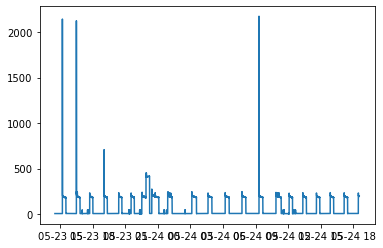

In [32]:
#Test
id = 11
plt.plot(test[sections[id].start:sections[id].end])

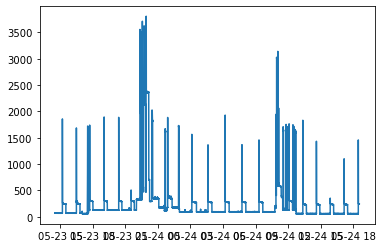

In [33]:
#Predict
id = 11
plt.plot(dae[sections[id].start:sections[id].end])

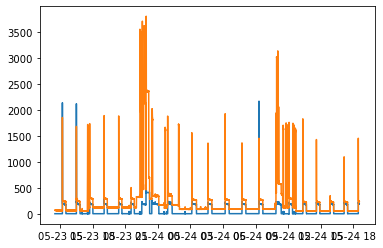

In [34]:
id = 11
plt.plot(test[sections[id].start:sections[id].end])
plt.plot(dae[sections[id].start:sections[id].end])
plt.show()

## Metricas

In [131]:
#31. Metricas de rendimiento: Comparación entre lo predicho y lo real
#32. Calcula los valores de tp, fp, fn, tn 
def tp_tn_fp_fn(states_pred, states_ground):
    # Calcula los estados logicos con comparadores and 1 and 1 = True
    tp = np.sum(np.logical_and(states_pred == 1, states_ground == 1))
    fp = np.sum(np.logical_and(states_pred == 1, states_ground == 0))
    fn = np.sum(np.logical_and(states_pred == 0, states_ground == 1))
    tn = np.sum(np.logical_and(states_pred == 0, states_ground == 0))
    return tp, tn, fp, fn

In [132]:
#33. Calcula el recall
def recall(tp,fn):
    return tp/float(tp+fn)
#34. La precision
def precision(tp,fp):
    return tp/float(tp+fp)
#35. El valor f1
def f1(prec,rec):
    return 2 * (prec*rec) / float(prec+rec)
#36. El accuracy
def accuracy(tp, tn, p, n):
    return (tp + tn) / float(p + n)

In [133]:
#37. Umbral donde se determina que el dispositivo esta encendido
# para el refrigerador se puede tomar un valor = 20W
threshold = 10

In [134]:
#38. Defino los datos de predicción y test como padans.df
prediccion = test[sections[id].start:sections[id].end]
real = dae[sections[id].start:sections[id].end]

In [164]:
#12. Une los indices comunes a las dos series de dispositivo y medidor
# Retorna una serie con los indices comunes
ix = prediccion.index.intersection(real.index)
ix

DatetimeIndex(['2011-05-23 10:31:34-04:00', '2011-05-23 10:31:38-04:00',
               '2011-05-23 10:31:41-04:00', '2011-05-23 10:31:45-04:00',
               '2011-05-23 10:31:48-04:00', '2011-05-23 10:31:52-04:00',
               '2011-05-23 10:31:55-04:00', '2011-05-23 10:31:58-04:00',
               '2011-05-23 10:32:02-04:00', '2011-05-23 10:32:05-04:00',
               ...
               '2011-05-24 14:31:25-04:00', '2011-05-24 14:31:34-04:00',
               '2011-05-24 14:31:37-04:00', '2011-05-24 14:31:41-04:00',
               '2011-05-24 14:31:44-04:00', '2011-05-24 14:31:48-04:00',
               '2011-05-24 14:31:51-04:00', '2011-05-24 14:31:55-04:00',
               '2011-05-24 14:31:58-04:00', '2011-05-24 14:32:01-04:00'],
              dtype='datetime64[ns, US/Eastern]', length=26220, freq=None)

In [166]:
#39. Detección de encendido para lo predicho y lo real
pr = np.array([0 if (p)<threshold else 1 for p in prediccion.values])  #Maestro predicho
gr = np.array([0 if p<threshold else 1 for p in real.values])    #Esclavo real

In [ ]:
#40. Calculo de verdaderos positivos, verdaderos negativos, 
# falsos positivos, falsos negativos, para el estado de encendido
tp, tn, fp, fn = tp_tn_fp_fn(pr,gr)

In [ ]:
# 41. Calculo del total de encendidos
# Suma de todos los 1 en pr o predicho
p = sum(pr)
#42. Calculo del total de apagados
# n es tamaño de pr - p que es su suma
n = len(pr) - p

In [ ]:
#43. Calculo el rendimiento mediante funciones propias de cada medida 
res_recall = recall(tp,fn)              # recall
res_precision = precision(tp,fp)        # precision
res_f1 = f1(res_precision,res_recall)   # f1 
res_accuracy = accuracy(tp,tn,p,n)      # accuracy

In [11]:
#44. Imprimir los valores resultantes
print(f"res_recall -------{rpaf[0]}")
print(f"res_precision ----{rpaf[1]}")
print(f"res_f1 -----------{rpaf[2]}")
print(f"res_accuracy -----{rpaf[2]}")

res_recall -------0.9995930374521819
res_precision ----0.8068757458333892
res_f1 -----------0.8066296935646431
res_accuracy -----0.8066296935646431


In [169]:
#Micro Ondas

In [35]:
#0. Cargar las librerias
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import warnings; warnings.filterwarnings('ignore')
from nilmtk import DataSet

In [36]:
#1. Cargar los datos
train = DataSet('C:\\Users\\josel\\SmartMeter\\OrdenandoTodo\\redd.h5')
#train.set_window(end="30-4-2011") #Use data only until 4/30/2011
#2. define el tamaño de los datos de entrenamiento
train.set_window(end="2011-04-30")
#3. Toma todos los medidores del edificio home = 1
home = 1
train_elec = train.buildings[home].elec

In [37]:
#4. Carga la libreria que define el modelo para una
#ventana de tiempo de 256 puntos por muestra
from daedisaggregator import DAEDisaggregator
dae = DAEDisaggregator(256) 

In [38]:
#5. Carga como medidor de entrenamiento el medidor central y el medidor para un dispositivo Fridge
train_mains = train_elec.mains().all_meters()[0] # El medidor agregado o central que proporciona la entrada
train_meter = train_elec.submeters()['microwave'] # El medidor de microondas que se utiliza como objetivo de entrenamiento.

In [39]:
#6. Llama la función de entrenamiento de la libreria
#para los medidores central y el de dispositivo, define el numero de epocas
#para el entrenamiento y el periodo de muestreo
dae.train(train_mains, train_meter, epochs=25, sample_period=1) # Entrena el modelo
dae.export_model("model-redd100.h5")                           # Exportar el modelo

Epoch 1/25
245/245 [==============================] - 9s 36ms/step - loss: 0.0017
Epoch 2/25
245/245 [==============================] - 9s 36ms/step - loss: 0.0016
Epoch 3/25
245/245 [==============================] - 9s 37ms/step - loss: 0.0015
Epoch 4/25
245/245 [==============================] - 9s 37ms/step - loss: 0.0015
Epoch 5/25
245/245 [==============================] - 9s 37ms/step - loss: 0.0016
Epoch 6/25
245/245 [==============================] - 9s 38ms/step - loss: 0.0015
Epoch 7/25
245/245 [==============================] - 9s 38ms/step - loss: 0.0015
Epoch 8/25
245/245 [==============================] - 9s 38ms/step - loss: 0.0015
Epoch 9/25
245/245 [==============================] - 9s 38ms/step - loss: 0.0013
Epoch 10/25
245/245 [==============================] - 9s 38ms/step - loss: 0.0012
Epoch 11/25
245/245 [==============================] - 11s 43ms/step - loss: 0.0014
Epoch 12/25
245/245 [==============================] - 10s 40ms/step - loss: 0.0010
Epoch 13/25

In [40]:
#7. Pruebas con los datos de test

#8. Carga los datos completos
test = DataSet('C:\\Users\\josel\\SmartMeter\\OrdenandoTodo\\redd.h5')
#9. Define el tamaño de la muestra de test
test.set_window(start="30-4-2011")
#10. Selecciona los electrodomesticos de un edificio
test_elec = test.buildings[1].elec
#11. Selecciona el medidor central
test_mains = test_elec.mains().all_meters()[0]

In [41]:
from nilmtk.datastore import HDFDataStore
#12. Carga el archivo del modelo entrenado
disag_filename = 'disag-out_2.h5' 
#13. Define el archivo como lectura
output = HDFDataStore(disag_filename, 'w')

In [42]:
#14. Disgregar el modelo segun el modelo entrenado
# test_mains: el medidor de señal agregado
# output: el almacén de datos de salida
# train_meter: se utiliza para copiar los metadatos del medidor de train en el almacén de datos. Esta serie se definio
# para el refrigerador
dae.disaggregate(test_mains, output, train_meter, sample_period=1)

New sensible chunk: 121482 size of data
New sensible chunk: 112661 size of data
New sensible chunk: 87770 size of data
New sensible chunk: 54084 size of data
New sensible chunk: 2660 size of data
New sensible chunk: 33513 size of data
New sensible chunk: 138535 size of data
New sensible chunk: 32514 size of data
New sensible chunk: 27255 size of data
New sensible chunk: 34833 size of data
New sensible chunk: 100831 size of data


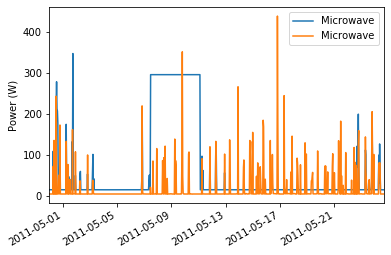

In [43]:
result = DataSet(disag_filename)
res_elec = result.buildings[1].elec
predicted = res_elec['microwave']
ground_truth = test_elec['microwave']
import metrics
import matplotlib.pyplot as plt
predicted.plot()
ground_truth.plot()
plt.show()

In [46]:
rpaf = metrics.recall_precision_accuracy_f1(predicted, ground_truth)
#44. Imprimir los valores resultantes
print(f"res_recall -------{rpaf[0]}")
print(f"res_precision ----{rpaf[1]}")
print(f"res_f1 -----------{rpaf[2]}")
print(f"res_accuracy -----{rpaf[2]}")

res_recall -------0.9999350147660893
res_precision ----0.7424549683884051
res_f1 -----------0.7424208714858577
res_accuracy -----0.7424208714858577


# Segundo Intento
Que funciones, es hora de descanzar de esto...

In [22]:
#0. Cargar funciones
from __future__ import print_function, division
import time

from matplotlib import rcParams
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from six import iteritems

from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore
from nilmtk.legacy.disaggregate import CombinatorialOptimisation, FHMM
import nilmtk.utils

%matplotlib inline
#Constante para el tamño de las imagenes
rcParams['figure.figsize'] = (16, 6)

In [23]:
# 1. Cargar los datos para entrenamiento. Uso todos los datos y los divido 
# segun una fecha definida por el usuario
train = DataSet('C:\\Users\\josel\\SmartMeter\\OrdenandoTodo\\redd.h5')
train.set_window(end="30-4-2011")      # Usando como final el 30 de abril
train_elec = train.buildings[1].elec   # Selecciono el edificio 1

A continuación, necesitamos definir el modelo de desagregación. Para este ejemplo, la ventana de entrada tendrá un tamaño de 256 muestras.

In [24]:
#Una estructura con 256 pasos en el tamaño de la muestra
sequence_length = 256

In [25]:
#5. Carga como medidor de entrenamiento el medidor central y el medidor para un dispositivo Fridge
train_mains = train_elec.mains().all_meters()[0] # El medidor agregado o central que proporciona la entrada
train_meter = train_elec.submeters()['microwave'] # El medidor de microondas que se utiliza como objetivo de entrenamiento.

In [32]:
#6. Cargar los datos de las series definidas
# Frecuencia de la muestra
load_kwargs = {'sample_period': 1}
# Esta función crea un generador de datos, si es necesario la remuestrea
# al periodo de tiempo definida por el usuario, en el caso de los medidores
# individuales rellena los espacios faltantes en el tiempo debido a que
# estan muestreados cada 3S.
main_power_series = train_mains.power_series(**load_kwargs)
meter_power_series = train_meter.power_series(**load_kwargs)

In [33]:
#7. Con next des empaqueta los datos en series de pandas antes definidas por un generador
mainchunk = next(main_power_series)          # Datos del medidor central
meterchunk = next(meter_power_series)        # Datos del electrodomestico

print(f"mainchunk tipo = {type(mainchunk)} tamaño = {mainchunk.shape}")
print(f"meterchunk tipo = {type(meterchunk)} tamaño = {meterchunk.shape}")

C:\Users\josel\Anaconda3\envs\nilmtk-env\lib\site-packages\nilmtk\elecmeter.py:446: UserWarning: The provided sample_period (1) is shorter than the meter's sample_period (3)
  sample_period, default_sample_period


mainchunk tipo = <class 'pandas.core.series.Series'> tamaño = (1003071,)
meterchunk tipo = <class 'pandas.core.series.Series'> tamaño = (1003066,)


In [34]:
mainchunk.head(5)

2011-04-18 09:22:09-04:00    224.190002
2011-04-18 09:22:10-04:00    225.570007
2011-04-18 09:22:11-04:00    226.089996
2011-04-18 09:22:12-04:00    222.740005
2011-04-18 09:22:13-04:00    222.199997
Freq: S, Name: (power, apparent), dtype: float32

In [35]:
meterchunk.head(5)

2011-04-18 09:22:13-04:00    5.0
2011-04-18 09:22:14-04:00    5.0
2011-04-18 09:22:15-04:00    5.0
2011-04-18 09:22:16-04:00    5.0
2011-04-18 09:22:17-04:00    5.0
Freq: S, Name: (power, active), dtype: float32

### Procesamiento de los datos antes de entrenar

In [36]:
# 8. Calcula el valor maximo del medidor central, con este valor se hace 
# la normalización de las series
mmax = None
if mmax == None:
    mmax = mainchunk.max()
mmax

4521.0400390625

In [37]:
# 9. Funciones para normalizar los datos con valores entre 0 y 1

# Normaliza las series de tiempo teniendo en cuenta el valor maximo
# mmax medido por el medidor central. 
def _normalize(chunk, mmax):
    tchunk = chunk / mmax
    return tchunk

# Des Normaliza las series de tiempo teniendo en cuenta el valor maximo
# mmax medido por el medidor central
def _denormalize(chunk, mmax):
    tchunk = chunk * mmax
    return tchunk

In [38]:
# 10. #Normaliza las series
mainchunk = _normalize(mainchunk, mmax)
meterchunk = _normalize(meterchunk, mmax)

In [39]:
mainchunk.head(5)

2011-04-18 09:22:09-04:00    0.049588
2011-04-18 09:22:10-04:00    0.049893
2011-04-18 09:22:11-04:00    0.050008
2011-04-18 09:22:12-04:00    0.049267
2011-04-18 09:22:13-04:00    0.049148
Freq: S, Name: (power, apparent), dtype: float64

In [40]:
meterchunk.head(5)

2011-04-18 09:22:13-04:00    0.001106
2011-04-18 09:22:14-04:00    0.001106
2011-04-18 09:22:15-04:00    0.001106
2011-04-18 09:22:16-04:00    0.001106
2011-04-18 09:22:17-04:00    0.001106
Freq: S, Name: (power, active), dtype: float64

In [41]:
#11. Tamaño de la secuencia definida para el modelo
s = sequence_length
#12. Remplaza valores NaNs con 0s
mainchunk.fillna(0, inplace=True)
meterchunk.fillna(0, inplace=True)

In [42]:
# 12. Une los indices comunes a las dos series de dispositivo y medidor
# Retorna una serie con los indices comunes en fechas
ix = mainchunk.index.intersection(meterchunk.index)
print(ix)

DatetimeIndex(['2011-04-18 09:22:13-04:00', '2011-04-18 09:22:14-04:00',
               '2011-04-18 09:22:15-04:00', '2011-04-18 09:22:16-04:00',
               '2011-04-18 09:22:17-04:00', '2011-04-18 09:22:18-04:00',
               '2011-04-18 09:22:19-04:00', '2011-04-18 09:22:20-04:00',
               '2011-04-18 09:22:21-04:00', '2011-04-18 09:22:22-04:00',
               ...
               '2011-04-29 23:59:49-04:00', '2011-04-29 23:59:50-04:00',
               '2011-04-29 23:59:51-04:00', '2011-04-29 23:59:52-04:00',
               '2011-04-29 23:59:53-04:00', '2011-04-29 23:59:54-04:00',
               '2011-04-29 23:59:55-04:00', '2011-04-29 23:59:56-04:00',
               '2011-04-29 23:59:57-04:00', '2011-04-29 23:59:58-04:00'],
              dtype='datetime64[ns, US/Eastern]', length=1003066, freq='S')


In [43]:
# 13. Toma los datos en las fechas coincidentes y descarta las demas
# seleccionando por medio de los indices definidos en ix
mainchunk = mainchunk[ix]
meterchunk = meterchunk[ix]

In [44]:
print(f"mainchunk  {mainchunk.shape}")
print(f"meterchunk {meterchunk.shape}")

mainchunk  (1003066,)
meterchunk (1003066,)


Este modelo cuenta con método de ventaneo para entrenar. Al hacer el ventaneo existe la posibilidad que la ultima ventana de tiempo quede incompleta. Es necesario rellenar los dato faltantes con ceros que no afectarán los pesos de las neuronas al entrenar, esto se debe a que un valor cero es similar a una neurona inactiva.

In [45]:
#14. Tamaño del batch de ceros
adicion = s - (len(ix) % s)
#A cada serie de medidor se le agrega el batch
#Se definen en función del tamaño de la muestra
#Esta operación elimina el indice de tipo tiempo
X_batch = np.append(mainchunk, np.zeros(adicion))    # Medidor central
Y_batch = np.append(meterchunk, np.zeros(adicion))   # Medidor de dispositivo

In [46]:
#15. Cambia la forma de los datos quedando la señal en tramos de 256 puntos chunk
#Para el ventanas de 256 seran (muestras = 3919, ventana = 256, Caracteristica = 1)
X_batch = np.reshape(X_batch, (int(len(X_batch) / s), s, 1))
Y_batch = np.reshape(Y_batch, (int(len(Y_batch) / s), s, 1))
print(f"X_batch {X_batch.shape}")
print(f"Y_batch {Y_batch.shape}")

X_batch (3919, 256, 1)
Y_batch (3919, 256, 1)


**NOta:** En este punto ya tenemos los datos de entrenamiento y objetivo listos para ser ingresados a cualquier modelo definido por nosotros.

## Modelo

In [48]:
#15. Creamos el modelo de auto encoder
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv1D, Reshape, Dropout
from keras.utils import plot_model

In [49]:
#16. Estructura del modelo
#Crea el contenedor del modelo
model = Sequential()

# 1D Conv filtros = 8, kernel = 4, entrada 256 pasos de 1 feature, padding igual, paso en 1
model.add(Conv1D(8, 4, activation="linear", input_shape=(sequence_length, 1), padding="same", strides=1))
#Aplanar la salida
model.add(Flatten())

#Auto encoder
# Fully Connected Layers abandono del 20%
model.add(Dropout(0.2))
# Neuronas 8 veces el tamaño de la ventana de tiempo = 2048 nodos
model.add(Dense((sequence_length-0)*8, activation='relu'))
#Abandono del 20% capa con 128 neuronas
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
#Abandono del 20% capa con 2048 nodos
model.add(Dropout(0.2))
model.add(Dense((sequence_length-0)*8, activation='relu'))

model.add(Dropout(0.2))

# 1D Conv
# La salida de la capa anterior es una secuencia aplanada. Es necesario cambiar
# el formato de los datos de salida para obtener datos de forma 256,8 similar
# a los pasos y filtros de la primer convolución
model.add(Reshape(((sequence_length-0), 8)))
#Entrega estos datos a una nueva capa convolucional 1 filtro con kernel = 4
#Supongo es de un solo filtro debido a que deseamos obtener una sola serie. 
model.add(Conv1D(1, 4, activation="linear", padding="same", strides=1))
#Compila el modelo con perdida mse y optimizador de adam
model.compile(loss='mse', optimizer='adam')
#Grafico del modelo para exportar
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 256, 8)            40        
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dropout_5 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               262272    
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)              

In [51]:
#17. Entrenando el modelo
batch_size = 16
epochs = 3
model.fit(X_batch, Y_batch, batch_size=batch_size, epochs=epochs, shuffle=True)

Epoch 1/3
245/245 [==============================] - 10s 41ms/step - loss: 0.0015
Epoch 2/3
245/245 [==============================] - 10s 41ms/step - loss: 0.0014
Epoch 3/3
245/245 [==============================] - 10s 41ms/step - loss: 0.0014


In [18]:
#Función para exportar el modelo en .h5
def export_model(filename):
    '''Guarda el modelo en .h5

    Parameters
    ----------
    filename : Nombre del archivo
    '''
    #Guardar el modelo. Requiere el nombre filename del archivo de salida, como opcional
    #inputs=inputs capa de entrada, outputs=outputs capa de salida es como hacer un corte
    model.save(filename)
    #Carga el archivo para lectura
    with h5py.File(filename, 'a') as hf:
        #Los grupos son la forma en la que se organizan los archivos h5
        #son similares a un diccionario. Las claves son los miembros del grupo
        #y los valores son los grupos. **Creo que sol los dataset**
        gr = hf.create_group('disaggregator-data')
        #Crea un nuevo dataset con metadotos nombre del conjunto de 
        #datos y matriz numpy con los datos
        gr.create_dataset('mmax', data = [mmax])

In [19]:
#export_model("model-redd100.h5")   

## Test de comportamiento

In [52]:
#18. Carga los datos completos
test = DataSet('C:\\Users\\josel\\SmartMeter\\OrdenandoTodo\\redd.h5')
#19. Define el tamaño de la muestra de test
test.set_window(start="30-4-2011") 
#20. Selecciona los electrodomesticos de un edificio
test_elec = test.buildings[1].elec
#21. Selecciona el medidor central en las fechas de test
test_mains = test_elec.mains().all_meters()[0]

In [53]:
#19. Definir una base de datos para guardar los resultados
from nilmtk.datastore import HDFDataStore
#20. Crea un archivo para guardar las series calculadas
disag_filename = 'disag-out.h5' 
#21. Define el archivo como lectura
output = HDFDataStore(disag_filename, 'w')

# INICIO CAMBIAR DATOS SI NO SIRVE BORRAR

En este punto los creadores de NILMTK hacen uso de su función desaggregator para re estructurar las muestras con las que se va a hacer el test. Este proceso consta de los siguientes pasos:
1. Para el objeto DAE que es de la clase DAEDisaggregator llama su función .disaggregate
2. Esta función recibe los siguientes parametros:
    - test_mains, series de test del medidor central
    - output, hdf5 en el que se guardan los resultados de predicción del modelo
    - train_meter, es la misma serie de cargada para el medidor objetivo solo se requieren sus metadatos
    - sample_period=1, es el periodo de muestreo de los datos.

Los procesos que se hacen dentro de esta función son los siguientes:
1. Verifica que antes de llamar esta función se haya hecho un entrenamiento de un modelo.
2. Verifica que se haya definido un valor del periodo de muestreo, si no se ha definido lo define por defecto a muestras de 60S: 'sample_period', 60
3. En load_kwargs establece los tiempos donde el medidor central funciono de manera adecuada, solo para el periodo de tiempo de test. En total hay 13 tiempos con su punto de inicio y fin: test_mains.good_sections()
4. Define un array para indices timeframes vacio:  timeframes = []
5. Define dos string que en un futuro serán las claves para guardar los metadatos de las predicciones que guardaremos en el archivo hdf5:
    -  building_path = '/building{}'.format(mains.building())  # /building1
    -  mains_data_location = building_path + '/elec/meter1'    # /building1/elec/meter1
6. Define una variable de control para verificar que ya hay metadatos para un grupo de datos creado: data_is_available = False
7. Recorre cada tramo de datos donde el medidor central funciono de forma correcta:

for chunk in mains.power_series(**load_kwargs):

**Parte 1**

Proceso para el bucle for chunk in mains.power_series(**load_kwargs):

1. Verifica la cantidad de datos en cada periodo de tiempo donde el medidor central funciono de manera adecuada. Si la longitud de los datos es menor al de las ventanas de tiempo del modelo, se descartan. Si no se sigue su procesamiento.

if len(chunk) < self.MIN_CHUNK_LENGTH:
2. Los tiempos que sean mayores a la ventana se guardan en una lista que se definio antes de este bucle:

timeframes.append(chunk.timeframe)
3. Define el nombre de las columnas de las series de datos ('power', 'apparent') en el iterador

measurement = chunk.name
4. Normaliza el tramo de serie del medidor y lo guarda en una nueva variable

chunk2 = self._normalize(chunk, self.mmax)
5. Ahora hace la predicción para esa serie de datos mediante otra función:
appliance_power = self.disaggregate_chunk(chunk2)   

Analisis disaggregate_chunk, esta función es la que calcula los datos disgregados para la entrada, retorna un df del mismo tamaño de los datos de entrada.

1. Recibe el tramo del medidor central mains (chunk2)
2. Define cual es el tamaño de los pasos de entrenamiento s = self.sequence_length
3. Define cual es el tamaño de los datos que ha recibido up_limit = len(mains)
4. Deja los valores nan como 0: mains.fillna(0, inplace=True)
5. Define el tamaño del batch de ceros para que todas las muestras sean del mismo tamaño additional = s - (up_limit % s) 
6. Crea la serie uniendo los datos al batch X_batch = np.append(mains, np.zeros(additional))
7. Crea las ventanas de tiempo X_batch = np.reshape(X_batch, (int(len(X_batch) / s), s ,1))
8. Mediante el modelo antes procesado calcula las predicciones para los datos de entrada que se definen en 7:

pred = self.model.predict(X_batch)
9. Cada predicción corresponde a una ventana de tiempo. Para retornan una sola serie une cada predicción hecha en un vector

pred = np.reshape(pred, (up_limit + additional))[:up_limit]

Descarta los datos de batch 0s que se agregaron a la ultima ventana.
10. Ahora une estos datos en un df.pandas el cual tiene como indice el indice de tiempo de la serie que se le entrego antes

column = pd.Series(pred, index=mains.index, name=0)
11. Ahora para no retornar una serie si no un df:
    - Define un diccionario vacio
      appliance_powers_dict = {}       
    - Ahora a una clave 0 le entregara la serie
      appliance_powers_dict[0] = column
    - Crea un df.pandas con este diccionario
      appliance_powers = pd.DataFrame(appliance_powers_dict)
12. Retorna este df

**Parte 2**
Proceso para el bucle for chunk in mains.power_series(**load_kwargs):

6. Al df de predicción calculado le elimina cualquier valor negativo tomandolos como 0s:
    
    appliance_power[appliance_power < 0] = 0
7. Calcula el valor real eliminando la normalización de los datos

appliance_power = self._denormalize(appliance_power, self.mmax)
8. En este punto ya tenemos el calculo de predicciones de una serie y la variable de control de datos disponibles cambia de estado:

data_is_available = True
9. Obtiene el nombre para las columnas de medida para cada serie cols = MultiIndex([('power', 'apparent')]

cols = pd.MultiIndex.from_tuples([chunk.name])
10. Define el id del medidor central por ejemplo para el refrigerador es el numero 5

meter_instance = meter_metadata.instance()
11. Crea un df mas completo con los valores de la serie predicha.

df = pd.DataFrame(
                appliance_power.values, index=appliance_power.index,
                columns=cols, dtype="float32")
12. Define el nombre de la clave con la cual se guardara este df en un archivo hdf5 /building1/elec/meter5 esta clave es la misma para cada tramo chunk que se use para hacer una predicción. 

key = '{}/elec/meter{}'.format(building_path, meter_instance)
13. Agrega el df al archivo hdf5 con la clave antes definida

output_datastore.append(key, df)
14. Ahora crea un df para el tramo de chunk del medidor central correspondiente a esta predicción

mains_df = pd.DataFrame(chunk, columns=cols, dtype="float32")
15. Con la clave del medidor central antes definida '/building1/elec/meter1'

16. Agrega el df del chunk del medidor central al archivo hdf5 pero con la clave para el medidor central

output_datastore.append(key=mains_data_location, value=mains_df)

**NOTA:** De esta manera cada df del medidor central y la predicción para el dispositivo se guardan de manera paralela en un solo archivo hdf5. 

17. Finalmente agrega metadatos al archivo hdf5 que permiten la navegación por ellos de manera mas ordenada mediante la función self._save_metadata_for_disaggregation() la idea es contruir una propia e ignorar la forma en que la hacen en la libreria. Pues el proceso no es transparente para mi y no me permite corroborar de manera directa el proceso que se ejecuto en estos algoritmos. 

# FIN CAMBIAR DATOS SI NO SIRVE BORRAR

In [25]:
nilmtk.datastore?

In [22]:
#23. Define un array para timeframes vacio
timeframes = []

#24. Crea un string con el nombre del edificio mas el id del edificio que lo
#toma desde los metadatos 
#ejemplo building1
building_path = '/building{}'.format(test_mains.building())
#25. Ahora crea el nombre de la ruta al medidor 1 del edificio en cuestión
#Pej.  building1/elec/meter1
mains_data_location = building_path + '/elec/meter1'

#Variable de control datos estan disponibles
data_is_available = False

In [23]:
from nilmtk.utils import find_nearest
from nilmtk.feature_detectors import cluster
from nilmtk.legacy.disaggregate import Disaggregator
from nilmtk.datastore import HDFDataStore

In [24]:
# Esta función es la encargada de calcular la serie de datos predicha por el modelo
# para cada tramo de los datos de test del medidor central. Estos tramos son los tomados
# solo en los casos donde el medidor funciono de manera adecuada. Al final retorna un
# df con los datos predichos por el modelo antes entrenado. 
def disaggregate_chunk(mains):
    ''' Desagregación en memoria.

     Parámetros
     ----------
     mains: pd. serie para desagregar
     Returns
     -------
     appliance_powers: pd.DataFrame donde cada columna representa un
         aparato desagregado. Los nombres de las columnas son el índice entero
         en `model` para el aparato en cuestión.
    '''
    # Tamaño de las ventanas de entrenamiento
    s = sequence_length
    # Tamaño de la sección de la serie que se cargada
    # según los instantes de buen funcionamiento del medidor
    up_limit = len(mains)
    # Rellenar los valores Nan con ceros
    mains.fillna(0, inplace=True)
    # Calcular la cantidad de ceros que deben llenarse 
    # para crear un batch que permita que los datos al 
    # dividirse mantengan el tamaño para todos los datos
    additional = s - (up_limit % s)
    # Crear series de datos con los batch de ceros al final
    X_batch = np.append(mains, np.zeros(additional))
    #Cambiar el formato de los datos como: numero de muestras
    # ventanas de tiempo = 256, y una caracteristica
    X_batch = np.reshape(X_batch, (int(len(X_batch) / s), s ,1))
    # Calcula la predicción para esta serie de tiempo en particular
    # En este punto tenemos datos con forma: (Muestras, ventana = 256, caracteristicas = 1)
    # Que es lo que retorna el modelo al predecir
    pred = model.predict(X_batch)
    # Ahora une todas las salidas en ventanas a una serie completa, de los cuales solo toma
    # los datos hasta donde la serie original tenia datos. Los datos restantes
    # son los tomados por el batch de ceros, por lo tanto, se eliminan de la predicción
    pred = np.reshape(pred, (up_limit + additional))[:up_limit]
    # Crea una serie de pandas, con los datos de pred, usa como indice los mismos indices de 
    # tiempo que tenia la serie original y como nombre la llama 0 este es un metadato
    column = pd.Series(pred, index=mains.index, name=0)

    # Crea un diccionario vacio con el creara un dataframe posteriormente
    # donde la clave key = 0 tendra como valor value la columna de datos predichos
    appliance_powers_dict = {}
    appliance_powers_dict[0] = column
    # Transforma el diccionario a un dataframe de pandas de esta manera 
    # agrega la dimension de las columnas = 1. Tal que (muestras, 1)
    appliance_powers = pd.DataFrame(appliance_powers_dict)
    # Y es este dataframe el que retorna
    return appliance_powers

In [25]:
# Al ejecutar el ciclo carga las series de datos remuestradas segun lo definido en 
# load_kwargs =  {'sample_period': 1, 'sections': [TimeFrame(start='2011-04-30 00:00:00-04:00', end='2011-05-01 09:44:42-04:00', empty=False)...]}
# Dedusco que solo tomara los datos que se encuentren en las secciones buenas del medidor.
# Cada chunk es una serie de pandas pandas.core.series.Series
MIN_CHUNK_LENGTH = 256

def disaggregate(mains, output_datastore, meter_metadata, **load_kwargs):
    #22. Cargar los instantentes donde el medidor central funciona de manera adecuada mains = test_mains
    load_kwargs.setdefault('sections', test_mains.good_sections())
    # Recorre cada sección de buen funcionamiento y para cada 
    # una calcula la prediccion del modelo
    print(f"meter_metadata {meter_metadata}")
    
    #cols = pd.MultiIndex.from_tuples([('power', 'apparent')])
    cont = 0
    datos = {}
    for chunk in mains.power_series(**load_kwargs):

        #Si el tamaño de la serie cargada es menor al de las ventanas se descarta
        if len(chunk) < MIN_CHUNK_LENGTH:
            continue
            
        #Imprime el tamaño de los tramos de series cargados
        print("Serie cargada: {}".format(len(chunk)))

        #Nombre de las columnas de series de datos ('power', 'apparent')
        measurement = chunk.name

        #Normaliza la serie cargada y la guarda en una nueva variable usando como
        #maximo el valor del medidor centrar de entrenamiento
        chunk2 = _normalize(chunk, mmax)

        # Predice para cada tramo la salida que debe tener el medidor del dispositivo
        # enviando el tramo de datos del medidor central. Retorna un dataframe de pandas.
        appliance_power = disaggregate_chunk(chunk2)
        
        # TOdo valor negativo calculado lo iguala a cero
        appliance_power[appliance_power < 0] = 0
        # Calcula el valor real mediante la desnormalización de los datos
        appliance_power = _denormalize(appliance_power, mmax)
        #print(f"appliance_power ****** \n {type(appliance_power)}")
        
        # Agregar predicción a la salida
        # En este punto tendremos datos disponibles predichos
        data_is_available = True
        # chunk.name = ('power', 'apparent') 
        # Convierte lista de tuplas a MultiIndex osea una estructura que contiene
        # multiples indices. Lons nombres estan dados pos la serie original
        # cols = MultiIndex([('power', 'apparent')]
        cols = pd.MultiIndex.from_tuples([chunk.name])
        # De los metadatos extrae el valor de la instancia de la medida
        # que en si es como el id del dispositivo por ejemplo 5 para refrigerador
        # en el edificio 1
        meter_instance = meter_metadata.instance()
        # Ahora crea un df para cada serie predicha chunk con: 
        # appliance_power.values = los valores de la serie predicha
        # index=appliance_power.index con indice el tiempo de dicha serie
        # columns=cols da el nombre de las columnas ('power', 'apparent') es el nombre 
        # de la columna de medidas, el indice no tiene nombre
        # y define los datos como  de punto flotante
        df = pd.DataFrame(
            appliance_power.values, index=appliance_power.index,
            columns=cols, dtype="float32")
        #Define el nombre de la ruta de cada dispositivo /building1/elec/meter5
        key = '{}/elec/meter{}'.format(building_path, meter_instance)
        # En el archivo output_datastore se agregaran los datos calculados en 
        # cada predicción 
        output_datastore.append(key, df)

        # Append aggregate data to output / Agregar datos agregados a la salida
        #Crea un dataframe para la serie de datos del medidor original
        mains_df = pd.DataFrame(chunk, columns=cols, dtype="float32")
        # Y tambien la agrega al archivo de salidas calculadas quedando en orden
        # datos predichos y luego datos originales del medidor
        output_datastore.append(key=mains_data_location, value=mains_df)
        
        datos[cont] =  appliance_power
        cont += 1
        '''
        if cont == 0:
            df_pred = mains_df.copy()
            cont += 1
        else:
            df_pred = pd.merge(df_pred, mains_df) 
        '''
    #return datos 
    return mains_df


In [26]:
# Esta función calcula las predicciones para los datos de test
dae = disaggregate(test_mains, output, train_meter, sample_period=1)

meter_metadata ElecMeter(instance=5, building=1, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])
Serie cargada: 121482
Serie cargada: 112661
Serie cargada: 87770
Serie cargada: 54084
Serie cargada: 2660
Serie cargada: 33513
Serie cargada: 138535
Serie cargada: 32514
Serie cargada: 27255
Serie cargada: 34833
Serie cargada: 100831


In [27]:
#Cargando los datos de test

In [28]:
test = test_elec.submeters()['fridge']
test = next(test.power_series())

En este punto los valores predichos tienen menor cantidad a los originales

In [29]:
test.index

DatetimeIndex(['2011-04-30 00:00:01-04:00', '2011-04-30 00:00:05-04:00',
               '2011-04-30 00:00:09-04:00', '2011-04-30 00:00:12-04:00',
               '2011-04-30 00:00:16-04:00', '2011-04-30 00:00:20-04:00',
               '2011-04-30 00:00:24-04:00', '2011-04-30 00:00:27-04:00',
               '2011-04-30 00:00:31-04:00', '2011-04-30 00:00:35-04:00',
               ...
               '2011-05-24 15:56:03-04:00', '2011-05-24 15:56:06-04:00',
               '2011-05-24 15:56:10-04:00', '2011-05-24 15:56:13-04:00',
               '2011-05-24 15:56:17-04:00', '2011-05-24 15:56:20-04:00',
               '2011-05-24 15:56:23-04:00', '2011-05-24 15:56:27-04:00',
               '2011-05-24 15:56:30-04:00', '2011-05-24 15:56:34-04:00'],
              dtype='datetime64[ns, US/Eastern]', length=489198, freq=None)

In [30]:
dae.index

DatetimeIndex(['2011-05-23 10:31:34-04:00', '2011-05-23 10:31:35-04:00',
               '2011-05-23 10:31:36-04:00', '2011-05-23 10:31:37-04:00',
               '2011-05-23 10:31:38-04:00', '2011-05-23 10:31:39-04:00',
               '2011-05-23 10:31:40-04:00', '2011-05-23 10:31:41-04:00',
               '2011-05-23 10:31:42-04:00', '2011-05-23 10:31:43-04:00',
               ...
               '2011-05-24 14:31:55-04:00', '2011-05-24 14:31:56-04:00',
               '2011-05-24 14:31:57-04:00', '2011-05-24 14:31:58-04:00',
               '2011-05-24 14:31:59-04:00', '2011-05-24 14:32:00-04:00',
               '2011-05-24 14:32:01-04:00', '2011-05-24 14:32:02-04:00',
               '2011-05-24 14:32:03-04:00', '2011-05-24 14:32:04-04:00'],
              dtype='datetime64[ns, US/Eastern]', length=100831, freq='S')

In [31]:
sections = [TimeFrame(start='2011-04-30 00:00:00-04:00', 
                                    end='2011-05-01 09:44:42-04:00'), 
                          TimeFrame(start='2011-05-01 09:47:18-04:00', 
                                    end='2011-05-02 17:04:59-04:00'), 
                          TimeFrame(start='2011-05-02 17:07:27-04:00', 
                                    end='2011-05-03 17:30:17-04:00'), 
                          TimeFrame(start='2011-05-03 17:32:49-04:00', 
                                    end='2011-05-03 17:33:44-04:00'), 
                          TimeFrame(start='2011-05-06 10:51:46-04:00', 
                                    end='2011-05-07 01:53:10-04:00'), 
                          TimeFrame(start='2011-05-07 01:53:55-04:00', 
                                    end='2011-05-07 02:38:15-04:00'), 
                          TimeFrame(start='2011-05-07 02:40:43-04:00', 
                                    end='2011-05-07 11:59:16-04:00'), 
                          TimeFrame(start='2011-05-11 03:19:43-04:00', 
                                    end='2011-05-12 17:48:38-04:00'), 
                          TimeFrame(start='2011-05-12 20:14:30-04:00', 
                                    end='2011-05-13 05:16:24-04:00'), 
                          TimeFrame(start='2011-05-22 16:04:46-04:00', 
                                    end='2011-05-22 23:39:01-04:00'), 
                          TimeFrame(start='2011-05-22 23:41:35-04:00', 
                                    end='2011-05-23 09:22:08-04:00'), 
                          TimeFrame(start='2011-05-23 10:31:34-04:00', 
                                    end='2011-05-24 14:32:05-04:00'), 
                          TimeFrame(start='2011-05-24 15:55:33-04:00', 
                                    end='2011-05-24 15:57:02-04:00')]

C:\Users\josel\Anaconda3\envs\nilmtk-env\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


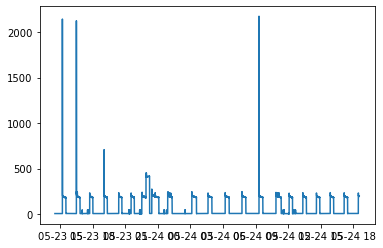

In [32]:
#Test
id = 11
plt.plot(test[sections[id].start:sections[id].end])

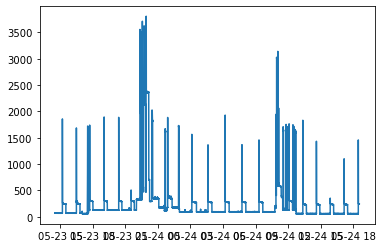

In [33]:
#Predict
id = 11
plt.plot(dae[sections[id].start:sections[id].end])

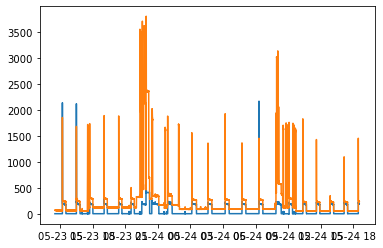

In [34]:
id = 11
plt.plot(test[sections[id].start:sections[id].end])
plt.plot(dae[sections[id].start:sections[id].end])
plt.show()

## Metricas

In [131]:
#31. Metricas de rendimiento: Comparación entre lo predicho y lo real
#32. Calcula los valores de tp, fp, fn, tn 
def tp_tn_fp_fn(states_pred, states_ground):
    # Calcula los estados logicos con comparadores and 1 and 1 = True
    tp = np.sum(np.logical_and(states_pred == 1, states_ground == 1))
    fp = np.sum(np.logical_and(states_pred == 1, states_ground == 0))
    fn = np.sum(np.logical_and(states_pred == 0, states_ground == 1))
    tn = np.sum(np.logical_and(states_pred == 0, states_ground == 0))
    return tp, tn, fp, fn

In [132]:
#33. Calcula el recall
def recall(tp,fn):
    return tp/float(tp+fn)
#34. La precision
def precision(tp,fp):
    return tp/float(tp+fp)
#35. El valor f1
def f1(prec,rec):
    return 2 * (prec*rec) / float(prec+rec)
#36. El accuracy
def accuracy(tp, tn, p, n):
    return (tp + tn) / float(p + n)

In [133]:
#37. Umbral donde se determina que el dispositivo esta encendido
# para el refrigerador se puede tomar un valor = 20W
threshold = 10

In [134]:
#38. Defino los datos de predicción y test como padans.df
prediccion = test[sections[id].start:sections[id].end]
real = dae[sections[id].start:sections[id].end]

In [164]:
#12. Une los indices comunes a las dos series de dispositivo y medidor
# Retorna una serie con los indices comunes
ix = prediccion.index.intersection(real.index)
ix

DatetimeIndex(['2011-05-23 10:31:34-04:00', '2011-05-23 10:31:38-04:00',
               '2011-05-23 10:31:41-04:00', '2011-05-23 10:31:45-04:00',
               '2011-05-23 10:31:48-04:00', '2011-05-23 10:31:52-04:00',
               '2011-05-23 10:31:55-04:00', '2011-05-23 10:31:58-04:00',
               '2011-05-23 10:32:02-04:00', '2011-05-23 10:32:05-04:00',
               ...
               '2011-05-24 14:31:25-04:00', '2011-05-24 14:31:34-04:00',
               '2011-05-24 14:31:37-04:00', '2011-05-24 14:31:41-04:00',
               '2011-05-24 14:31:44-04:00', '2011-05-24 14:31:48-04:00',
               '2011-05-24 14:31:51-04:00', '2011-05-24 14:31:55-04:00',
               '2011-05-24 14:31:58-04:00', '2011-05-24 14:32:01-04:00'],
              dtype='datetime64[ns, US/Eastern]', length=26220, freq=None)

In [166]:
#39. Detección de encendido para lo predicho y lo real
pr = np.array([0 if (p)<threshold else 1 for p in prediccion.values])  #Maestro predicho
gr = np.array([0 if p<threshold else 1 for p in real.values])    #Esclavo real

In [ ]:
#40. Calculo de verdaderos positivos, verdaderos negativos, 
# falsos positivos, falsos negativos, para el estado de encendido
tp, tn, fp, fn = tp_tn_fp_fn(pr,gr)

In [ ]:
# 41. Calculo del total de encendidos
# Suma de todos los 1 en pr o predicho
p = sum(pr)
#42. Calculo del total de apagados
# n es tamaño de pr - p que es su suma
n = len(pr) - p

In [ ]:
#43. Calculo el rendimiento mediante funciones propias de cada medida 
res_recall = recall(tp,fn)              # recall
res_precision = precision(tp,fp)        # precision
res_f1 = f1(res_precision,res_recall)   # f1 
res_accuracy = accuracy(tp,tn,p,n)      # accuracy

In [11]:
#44. Imprimir los valores resultantes
print(f"res_recall -------{rpaf[0]}")
print(f"res_precision ----{rpaf[1]}")
print(f"res_f1 -----------{rpaf[2]}")
print(f"res_accuracy -----{rpaf[2]}")

res_recall -------0.9995930374521819
res_precision ----0.8068757458333892
res_f1 -----------0.8066296935646431
res_accuracy -----0.8066296935646431
